# **BA820 - Milestone 4: Refinement** <n>
**Individual Analysis - iMDB Ratings (*Alone* TV Show Dataset)**<n>

**Name:** Akbar Wibowo <n>

**Business Question:**
Are IMDb ratings mostly consistent, or are there clear high and low rated episodes or seasons

---

**Executive Summary** <n>

This notebook refines the episode segmentation analysis for the question: are IMDb ratings for Alone broadly consistent, or do clear high and low reception groups exist across episodes and seasons. Milestone 4 focuses on refinement rather than discovery by testing the sensitivity of clustering results to the number of clusters (k equals 3 versus k equals 5), to the inclusion of viewership (X1 versus X2 and X3), and to missing viewership handling (complete case versus median imputation). Results show that k equals 3 provides simple, interpretable buckets, while k equals 5 adds useful detail by splitting the mid range region into more specific tiers without changing the core story. Adding viewership changes membership somewhat, but complete case and imputed viewer versions are highly consistent with each other, suggesting missingness is not driving the viewership sensitivity results. A method robustness check using hierarchical clustering aligns strongly with KMeans, especially under k equals 5, supporting the conclusion that the refined segmentation is not dependent on a single clustering method.

# A. Import Libraries, Data Loading and Preprocessing, and Preliminary EDA

In [77]:
#A.1 Importing libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
!pip -q install plotly

In [78]:
#A.2 Loading Data
#Episodes data
episodes_url = "https://drive.google.com/uc?export=download&id=1Q2s1TZAl1epx_-hi8yXWQv12UJGt_LYe"
episodes_data = pd.read_csv(episodes_url)

#Seasons data
seasons_url = "https://drive.google.com/uc?export=download&id=1M1cEpgPXD1PTLywN2JD7Dn8-QEWcUfWQ"
seasons_data = pd.read_csv(seasons_url)

#View first few rows
print(episodes_data.head())
print(seasons_data.head())

#Focus on US version only
if "version" in episodes_data.columns:
    episodes_data = episodes_data[episodes_data["version"] == "US"].copy()

if "version" in seasons_data.columns:
    seasons_data = seasons_data[seasons_data["version"] == "US"].copy()

episodes_data["air_date"] = pd.to_datetime(episodes_data["air_date"], errors="coerce")
print("air_date missing after parsing:", episodes_data["air_date"].isna().sum())

  version  season  episode_number_overall  episode               title  \
0      US       1                       1        1    And So It Begins   
1      US       1                       2        2     Of Wolf and Man   
2      US       1                       3        3  The Talons of Fear   
3      US       1                       4        4             Stalked   
4      US       1                       5        5       Winds of Hell   

     air_date  viewers                                              quote  \
0  2015-06-18    1.582  I went to the woods because I wished to live d...   
1  2015-06-25    1.697  If you live among wolves you have to act like ...   
2  2015-07-02    1.864  Extinction is the rule. Survival is the except...   
3  2015-07-09    2.082  Hunger, love, pain, fear are some of those inn...   
4  2015-07-16    2.082    The strong survive, but the courageous triumph.   

                author  imdb_rating  n_ratings  
0  Henry David Thoreau          7.5      13

In [79]:
#A.3 Data Cleaning and Pre-processing
print("Episodes (US) shape:", episodes_data.shape)
print("Seasons (US) shape:", seasons_data.shape)

print("Episodes (US) columns:", episodes_data.columns)

dup_mask = episodes_data.duplicated(subset=["season", "episode"], keep=False)
dups = episodes_data.loc[dup_mask, ["season", "episode", "title", "air_date", "imdb_rating"]]
print("Duplicate (season, episode) rows:", dups.shape[0])
if dups.shape[0] > 0:
    display(dups.sort_values(["season", "episode"]))

key_cols = ["imdb_rating", "n_ratings", "viewers", "air_date", "season", "episode", "title"]
missing = episodes_data[key_cols].isna().sum().to_frame("missing_count")
missing["missing_pct"] = (missing["missing_count"] / len(episodes_data)).round(4)
display(missing)

episodes_r = episodes_data.dropna(subset=["imdb_rating"]).copy()
episodes_r_v = episodes_r.dropna(subset=["viewers"]).copy()

print("Rows with non-missing imdb_rating:", len(episodes_r), "out of", len(episodes_data))
print("Rows with non-missing viewers (within rated episodes):", len(episodes_r_v), "out of", len(episodes_r))

episodes_r["episode_id"] = episodes_r["season"].astype(str) + "_" + episodes_r["episode"].astype(str)
episodes_r_v["episode_id"] = episodes_r_v["season"].astype(str) + "_" + episodes_r_v["episode"].astype(str)

Episodes (US) shape: (98, 11)
Seasons (US) shape: (9, 8)
Episodes (US) columns: Index(['version', 'season', 'episode_number_overall', 'episode', 'title',
       'air_date', 'viewers', 'quote', 'author', 'imdb_rating', 'n_ratings'],
      dtype='object')
Duplicate (season, episode) rows: 0


,missing_count,missing_pct
imdb_rating,5,0.0510
n_ratings,5,0.0510
viewers,15,0.1531
air_date,0,0.0000
season,0,0.0000
episode,0,0.0000
title,0,0.0000


Rows with non-missing imdb_rating: 93 out of 98
Rows with non-missing viewers (within rated episodes): 83 out of 93


While episodes_r is created here for quick baseline checks on rated episodes, all clustering experiments in later sections use the standardized M4 datasets episodes_base, episodes_view, and episodes_imp to ensure consistent inputs across comparisons.

In [80]:
#A.4 Defining datasets for M4
episodes_base = episodes_data.dropna(subset=["imdb_rating", "n_ratings"]).copy()
print("episodes_base shape:", episodes_base.shape)

episodes_view = episodes_data.dropna(subset=["imdb_rating", "n_ratings", "viewers"]).copy()
print("episodes_view shape:", episodes_view.shape)

episodes_base["episode_id"] = episodes_base["season"].astype(str) + "_" + episodes_base["episode"].astype(str)
episodes_view["episode_id"] = episodes_view["season"].astype(str) + "_" + episodes_view["episode"].astype(str)

print("Rows dropped when requiring viewers:", len(episodes_base) - len(episodes_view))

episodes_imp = episodes_base.copy()
episodes_imp["viewers"] = episodes_imp["viewers"].fillna(episodes_imp["viewers"].median())
print("episodes_imp shape:", episodes_imp.shape)

missing_viewers_rows = episodes_base[episodes_base["viewers"].isna()][["season", "episode", "title", "imdb_rating", "n_ratings", "viewers"]]
if len(missing_viewers_rows) > 0:
    display(missing_viewers_rows.sort_values(["season", "episode"]))
print("Episodes missing viewers (within episodes_base):", len(missing_viewers_rows))
display(missing_viewers_rows.sort_values(["season", "episode"]))

print("Missing viewers by season:")
display(missing_viewers_rows["season"].value_counts().sort_index())

episodes_base shape: (93, 11)
episodes_view shape: (83, 11)
Rows dropped when requiring viewers: 10
episodes_imp shape: (93, 12)


,season,episode,title,imdb_rating,n_ratings,viewers
7,1,8,After the Rescue,7.7,99.0,NaN
84,8,9,The Troll,7.7,38.0,NaN
85,8,10,All In,7.8,39.0,NaN
86,8,11,The Reckoning,8.1,47.0,NaN
87,9,1,Drop Shock,7.9,41.0,NaN
88,9,2,Consequences,7.5,31.0,NaN
89,9,3,The Law of the Land,7.5,32.0,NaN
90,9,4,The Beaver,8.3,31.0,NaN
91,9,5,The Land Giveth…,7.8,26.0,NaN
97,9,11,"Fight, Flight or Freeze",8.6,5.0,NaN


Episodes missing viewers (within episodes_base): 10


,season,episode,title,imdb_rating,n_ratings,viewers
7,1,8,After the Rescue,7.7,99.0,NaN
84,8,9,The Troll,7.7,38.0,NaN
85,8,10,All In,7.8,39.0,NaN
86,8,11,The Reckoning,8.1,47.0,NaN
87,9,1,Drop Shock,7.9,41.0,NaN
88,9,2,Consequences,7.5,31.0,NaN
89,9,3,The Law of the Land,7.5,32.0,NaN
90,9,4,The Beaver,8.3,31.0,NaN
91,9,5,The Land Giveth…,7.8,26.0,NaN
97,9,11,"Fight, Flight or Freeze",8.6,5.0,NaN


Missing viewers by season:


,count
season,
1,1
8,3
9,6


The cell block above defines three analysis datasets based on what is missing in the episode table. episodes_base contains all episodes with IMDb rating and vote count available and serves as the main dataset, while episodes_view is a smaller subset that also has viewership and is used only for sensitivity analysis. episodes_imp keeps the full baseline set but fills missing viewership values with the median, which allows a robustness check to see whether missing viewership could change conclusions.

In [81]:
#A.5 Feature sets and scaling
from sklearn.preprocessing import StandardScaler

def make_scaled(df, cols):
    X = df[cols].copy()
    sc = StandardScaler()
    Xs = pd.DataFrame(sc.fit_transform(X), columns=cols, index=df.index)
    return X, Xs, sc

X1, X1s, sc1 = make_scaled(episodes_base, ["imdb_rating", "n_ratings"])
print("X1 shape:", X1.shape)

X2, X2s, sc2 = make_scaled(episodes_view, ["imdb_rating", "n_ratings", "viewers"])
print("X2 shape:", X2.shape)

X3, X3s, sc3 = make_scaled(episodes_imp, ["imdb_rating", "n_ratings", "viewers"])
print("X3 shape:", X3.shape)

display(X1s.head())

X1 shape: (93, 2)
X2 shape: (83, 3)
X3 shape: (93, 3)


,imdb_rating,n_ratings
0,-0.884879,3.608594
1,-0.334419,2.356918
2,-0.334419,2.056516
3,-0.334419,2.056516
4,-0.609649,1.806181


This specific code block constructs the feature matrices used in the experiments and standardizes them so that distance based clustering is not dominated by variables on larger scales. X1 uses rating and vote count and is the primary feature set. X2 adds viewership but only for complete cases, while X3 adds viewership using the imputed dataset to keep all baseline episodes, allowing a direct comparison of complete case versus imputed sensitivity.

# B. Clustering Experiments and Model Features


---


This section moves from setup into the clustering experiments used to refine the episode segmentation results from earlier milestones. The goal is to test whether reception based clusters are stable under different feature sets and reasonable modeling choices, rather than relying on a single run. The experiments begin with basic diagnostics to guide the number of clusters, then proceed to refinement checks in later cells.

,k,inertia,silhouette
0,2,123.815082,0.409972
1,3,78.157398,0.380771
2,4,57.344851,0.389758
3,5,43.307885,0.432206
4,6,35.210183,0.423205
5,7,29.278528,0.420944
6,8,23.721023,0.432933
7,9,19.628864,0.438456
8,10,16.692717,0.442679


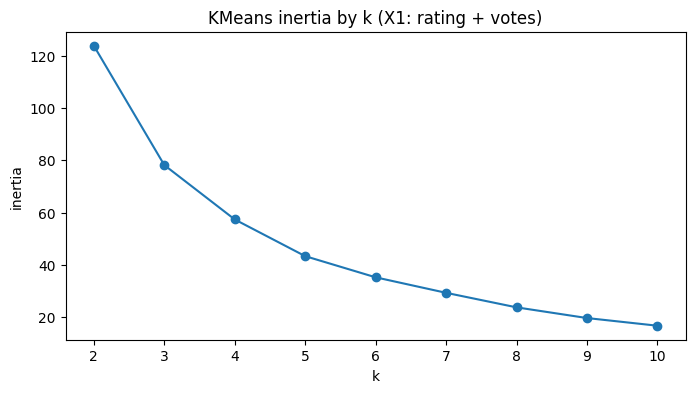

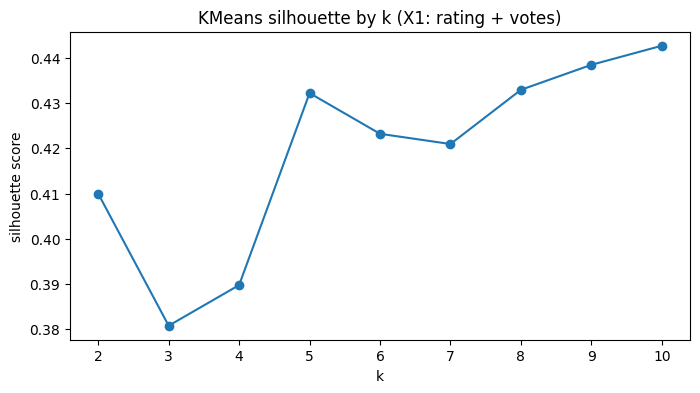

In [82]:
#B.1 KMeans diagnostics (Clustering Experiments and Model Features)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_range = range(2, 11)

rows = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X1s)
    sil = silhouette_score(X1s, labels)
    rows.append({"k": k, "inertia": km.inertia_, "silhouette": sil})

km_diag = pd.DataFrame(rows)
display(km_diag)

plt.figure(figsize=(8, 4))
plt.plot(km_diag["k"], km_diag["inertia"], marker="o")
plt.title("KMeans inertia by k (X1: rating + votes)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(km_diag["k"], km_diag["silhouette"], marker="o")
plt.title("KMeans silhouette by k (X1: rating + votes)")
plt.xlabel("k")
plt.ylabel("silhouette score")
plt.show()

Cell 6 evaluates plausible values of k using both inertia and silhouette on the baseline feature set. The inertia curve drops steeply from k equals 2 through roughly k equals 5 and then flattens, suggesting diminishing returns after that point. Silhouette values improve noticeably around k equals 5 and continue to increase gradually at higher k, so k equals 5 is a reasonable choice if the priority is cluster separation, while smaller k values such as 3 remain acceptable if interpretability and simpler “bucket” definitions are the priority. Given this tradeoff, both k = 3 and k = 5 are carried forward: k = 3 as a simpler baseline segmentation, and k = 5 as a refinement to test whether additional structure emerges without changing the overall narrative.

In [83]:
#B.2 Fit KMeans for k=3 and k=5 on X1 (rating + votes)
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import pandas as pd

def kmeans_labels(Xs, k, seed=42):
    km = KMeans(n_clusters=k, random_state=seed, n_init=10)
    labels = km.fit_predict(Xs)
    return labels

labels_k3 = kmeans_labels(X1s, 3, seed=42)
labels_k5 = kmeans_labels(X1s, 5, seed=42)

episodes_base = episodes_base.copy()
episodes_base["cluster_k3"] = labels_k3.astype(str)
episodes_base["cluster_k5"] = labels_k5.astype(str)

print("Cluster sizes (k=3):")
print(episodes_base["cluster_k3"].value_counts().sort_index())
print("\nCluster sizes (k=5):")
print(episodes_base["cluster_k5"].value_counts().sort_index())

ari_3_5 = adjusted_rand_score(labels_k3, labels_k5)
print("\nAdjusted Rand Index (k=3 vs k=5):", round(ari_3_5, 3))

Cluster sizes (k=3):
cluster_k3
0    44
1    12
2    37
Name: count, dtype: int64

Cluster sizes (k=5):
cluster_k5
0    21
1    13
2    11
3    13
4    35
Name: count, dtype: int64

Adjusted Rand Index (k=3 vs k=5): 0.339


From fitting the two KMeans segmentations on the same standardized baseline feature set (IMDb rating and vote count), the k equals 3 solution produces three broad reception buckets while the k equals 5 solution produces a finer segmentation with smaller groups. The k equals 3 cluster sizes are 44, 12, and 37, whereas the k equals 5 cluster sizes are 21, 13, 11, 13, and 35, indicating that the refined setting splits the data into more granular subgroups. The Adjusted Rand Index of 0.339 shows that moving from k equals 3 to k equals 5 meaningfully changes membership, so k equals 5 should be treated as a refinement rather than a minor variation.

In [84]:
#B.3 Cluster summaries for k=3 and k=5
def cluster_summary(df, label_col):
    return (
        df.groupby(label_col)
        .agg(
            n=("imdb_rating", "size"),
            mean_rating=("imdb_rating", "mean"),
            std_rating=("imdb_rating", "std"),
            mean_votes=("n_ratings", "mean"),
            min_rating=("imdb_rating", "min"),
            max_rating=("imdb_rating", "max"),
        )
        .sort_index()
    )

summary_k3 = cluster_summary(episodes_base, "cluster_k3")
summary_k5 = cluster_summary(episodes_base, "cluster_k5")

print("Cluster summary (k=3):")
display(summary_k3)

print("Cluster summary (k=5):")
display(summary_k5)

Cluster summary (k=3):


,n,mean_rating,std_rating,mean_votes,min_rating,max_rating
cluster_k3,,,,,,
0,44,7.552273,0.227717,57.068182,6.9,7.8
1,12,7.766667,0.214617,101.500000,7.5,8.2
2,37,8.159459,0.240900,57.378378,7.9,8.8


Cluster summary (k=5):


,n,mean_rating,std_rating,mean_votes,min_rating,max_rating
cluster_k5,,,,,,
0,21,8.038095,0.201187,43.761905,7.7,8.6
1,13,8.376923,0.204751,72.615385,8.1,8.8
2,11,7.736364,0.196330,103.090909,7.5,8.2
3,13,7.330769,0.225036,46.153846,6.9,7.6
4,35,7.694286,0.187778,64.428571,7.3,8.0


The cluster profile summaries help make the segment meaning interpretable. With k equals 3, the groups separate into a lower rated bucket, a higher rated bucket, and a distinct high vote bucket, which suggests that vote volume behaves like an engagement signal that is not the same thing as rating level. With k equals 5, the high vote pattern remains visible, but the rating structure becomes more granular, splitting the broad rating buckets into multiple tiers and isolating a clearer low rated group. Overall, this supports treating k equals 5 as a refinement that adds detail rather than replacing the core reception narrative.

In [85]:
#B.4 Season by cluster distribution for k=3 and k=5
season_pct_k3 = pd.crosstab(
    episodes_base["season"],
    episodes_base["cluster_k3"],
    normalize="index"
).round(3)

season_pct_k5 = pd.crosstab(
    episodes_base["season"],
    episodes_base["cluster_k5"],
    normalize="index"
).round(3)

print("Season by cluster distribution (k=3):")
display(season_pct_k3)

print("Season by cluster distribution (k=5):")
display(season_pct_k5)

Season by cluster distribution (k=3):


cluster_k3,0,1,2
season,,,
1,0.091,0.909,0.000
2,1.000,0.000,0.000
3,0.600,0.000,0.400
4,1.000,0.000,0.000
5,0.200,0.000,0.800
6,0.273,0.000,0.727
7,0.000,0.091,0.909
8,0.545,0.091,0.364
9,0.500,0.000,0.500


Season by cluster distribution (k=5):


cluster_k5,0,1,2,3,4
season,,,,,
1,0.000,0.000,0.909,0.000,0.091
2,0.000,0.000,0.000,0.000,1.000
3,0.100,0.000,0.000,0.000,0.900
4,0.000,0.000,0.000,1.000,0.000
5,0.800,0.000,0.000,0.000,0.200
6,0.455,0.182,0.000,0.000,0.364
7,0.000,1.000,0.000,0.000,0.000
8,0.273,0.000,0.091,0.091,0.545
9,0.667,0.000,0.000,0.333,0.000


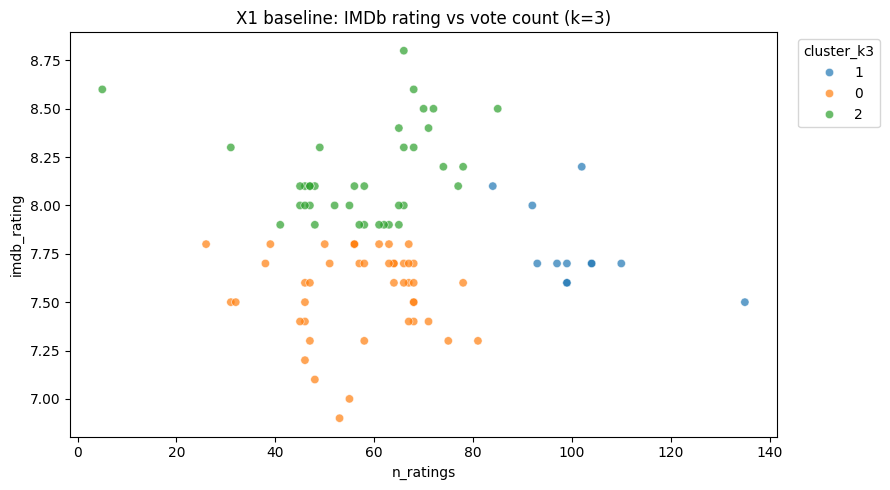

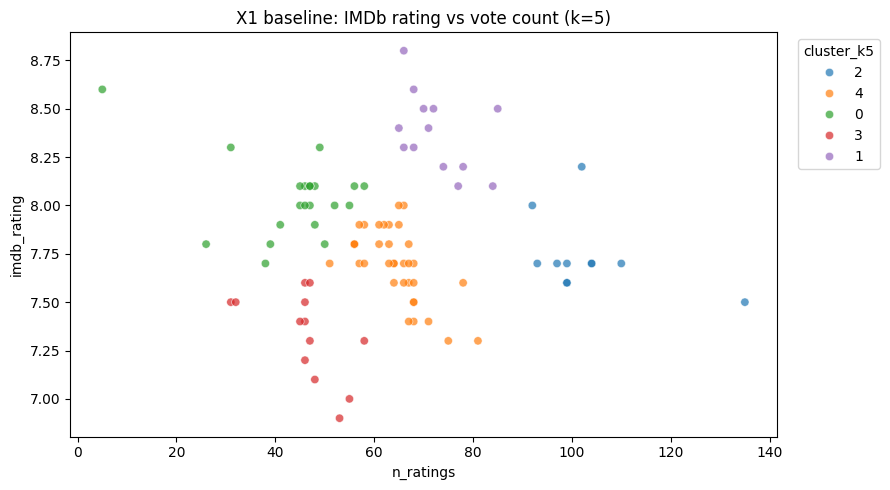

In [86]:
#B.5 Season by cluster distribution for k=3 and k=5 Scatter
plt.figure(figsize=(9, 5))
sns.scatterplot(
    data=episodes_base,
    x="n_ratings",
    y="imdb_rating",
    hue="cluster_k3",
    alpha=0.7
)
plt.title("X1 baseline: IMDb rating vs vote count (k=3)")
plt.xlabel("n_ratings")
plt.ylabel("imdb_rating")
plt.legend(title="cluster_k3", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))
sns.scatterplot(
    data=episodes_base,
    x="n_ratings",
    y="imdb_rating",
    hue="cluster_k5",
    alpha=0.7
)
plt.title("X1 baseline: IMDb rating vs vote count (k=5)")
plt.xlabel("n_ratings")
plt.ylabel("imdb_rating")
plt.legend(title="cluster_k5", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

The season-by-cluster tables convert raw counts into within-season percentages, which makes it easier to compare seasons that have different numbers of episodes. Under k equals 3, several seasons concentrate heavily into a single bucket, suggesting that reception patterns are not randomly distributed across seasons. This aligns with the X1 scatterplot of IMDb rating versus vote count (k equals 3), which shows three visually distinct regions: a higher-rated group, a lower-rated group, and a higher-vote “engagement” group, reinforcing that the clusters reflect meaningful structure rather than minor numeric variation. Under k equals 5, those season concentrations become more specific, with some seasons mapping almost entirely into a single refined tier, which strengthens the interpretation that season-level reception differs in a structured way rather than being purely episode-to-episode noise.

In [87]:
#B.6 Crosstab: how k=5 splits the k=3 buckets
split_table = pd.crosstab(episodes_base["cluster_k3"], episodes_base["cluster_k5"])
display(split_table)

cluster_k5,0,1,2,3,4
cluster_k3,,,,,
0,4,0,0,13,27
1,0,1,11,0,0
2,17,12,0,0,8


The crosstab shows how the k equals 5 solution refines the k equals 3 buckets by splitting each broad group into smaller subgroups. Rather than forming an entirely different segmentation, the k equals 5 labels mostly redistribute episodes within the existing k equals 3 structure, which is consistent with the moderate ARI observed earlier. This supports interpreting k equals 3 as a high level set of reception buckets and k equals 5 as a refinement that reveals subtypes within those buckets, especially where vote volume and rating tiers vary within the same coarse group.

# C. Sensitivity Checks Using Viewership and Missing Data Handling


---


This section tests whether the clustering patterns from the baseline feature set remain consistent when viewership is added and when missing viewership is handled in different ways. Two versions are compared: a complete-case dataset that only keeps episodes with recorded viewers (X2), and an imputed dataset that fills missing viewers to retain the full baseline sample (X3). The goal is to see whether the same high-level segmentation holds, or whether viewership and missingness meaningfully shift the cluster structure.

## C.1 X2 Complete case model (ratings, votes, viewers)

In [88]:
#C.1.1 X2 Complete case model (ratings, votes, viewers)
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import pandas as pd

def kmeans_labels(Xs, k, seed=42):
    km = KMeans(n_clusters=k, random_state=seed, n_init=10)
    return km.fit_predict(Xs)

labels_x2_k3 = kmeans_labels(X2s, 3, seed=42)
labels_x2_k5 = kmeans_labels(X2s, 5, seed=42)

episodes_view = episodes_view.copy()
episodes_view["cluster_X2_k3"] = labels_x2_k3.astype(str)
episodes_view["cluster_X2_k5"] = labels_x2_k5.astype(str)

print("X2 cluster sizes (k=3):")
print(episodes_view["cluster_X2_k3"].value_counts().sort_index())
print("\nX2 cluster sizes (k=5):")
print(episodes_view["cluster_X2_k5"].value_counts().sort_index())

x1_map_k3 = episodes_base.set_index("episode_id")["cluster_k3"]
x1_map_k5 = episodes_base.set_index("episode_id")["cluster_k5"]

x2_ids = episodes_view["episode_id"].values
x1_k3_overlap = x1_map_k3.loc[x2_ids].astype(int).values
x1_k5_overlap = x1_map_k5.loc[x2_ids].astype(int).values

ari_x1x2_k3 = adjusted_rand_score(x1_k3_overlap, labels_x2_k3)
ari_x1x2_k5 = adjusted_rand_score(x1_k5_overlap, labels_x2_k5)

print("\nAgreement with X1 baseline on overlapping episodes:")
print("ARI (k=3):", round(ari_x1x2_k3, 3))
print("ARI (k=5):", round(ari_x1x2_k5, 3))

X2 cluster sizes (k=3):
cluster_X2_k3
0    31
1    42
2    10
Name: count, dtype: int64

X2 cluster sizes (k=5):
cluster_X2_k5
0    22
1    23
2    10
3    14
4    14
Name: count, dtype: int64

Agreement with X1 baseline on overlapping episodes:
ARI (k=3): 0.55
ARI (k=5): 0.419


Adding viewership while restricting to complete cases produces a similar overall structure to the baseline, but the match is not perfect. With k = 3, the X2 clusters have sizes 31, 42, and 10, and the agreement with the X1 baseline on the same episodes is ARI = 0.55, which indicates a moderate level of consistency. With k = 5, the X2 clusters split into 22, 23, 10, 14, and 14, and agreement drops to ARI = 0.419, suggesting that the finer segmentation is more sensitive to adding viewership. Overall, including viewers does not erase the baseline pattern, but it changes membership enough that viewers should be treated as a sensitivity feature rather than assumed to be neutral.

In [89]:
#C.1.2 X2 summaries (k=3 and k=5)
def cluster_summary(df, label_col):
    return (
        df.groupby(label_col)
        .agg(
            n=("imdb_rating", "size"),
            mean_rating=("imdb_rating", "mean"),
            std_rating=("imdb_rating", "std"),
            mean_votes=("n_ratings", "mean"),
            mean_viewers=("viewers", "mean"),
            min_rating=("imdb_rating", "min"),
            max_rating=("imdb_rating", "max"),
        )
        .sort_index()
    )

summary_X2_k3 = cluster_summary(episodes_view, "cluster_X2_k3")
summary_X2_k5 = cluster_summary(episodes_view, "cluster_X2_k5")

print("X2 cluster summary (k=3):")
display(summary_X2_k3)

print("X2 cluster summary (k=5):")
display(summary_X2_k5)

season_pct_X2_k3 = pd.crosstab(episodes_view["season"], episodes_view["cluster_X2_k3"], normalize="index").round(3)
season_pct_X2_k5 = pd.crosstab(episodes_view["season"], episodes_view["cluster_X2_k5"], normalize="index").round(3)

print("X2 season-by-cluster (k=3):")
display(season_pct_X2_k3)

print("X2 season-by-cluster (k=5):")
display(season_pct_X2_k5)

X2 cluster summary (k=3):


,n,mean_rating,std_rating,mean_votes,mean_viewers,min_rating,max_rating
cluster_X2_k3,,,,,,,
0,31,8.151613,0.260603,63.483871,1.304000,7.6,8.8
1,42,7.597619,0.266402,58.976190,1.587929,6.9,8.1
2,10,7.670000,0.226323,101.800000,1.969700,7.3,8.2


X2 cluster summary (k=5):


,n,mean_rating,std_rating,mean_votes,mean_viewers,min_rating,max_rating
cluster_X2_k5,,,,,,,
0,22,7.786364,0.142413,60.727273,1.697636,7.5,8.1
1,23,7.891304,0.210871,55.391304,1.308783,7.6,8.3
2,10,7.670000,0.226323,101.800000,1.969700,7.3,8.2
3,14,8.350000,0.221012,74.000000,1.304643,8.0,8.8
4,14,7.292857,0.181720,57.071429,1.528714,6.9,7.5


X2 season-by-cluster (k=3):


cluster_X2_k3,0,1,2
season,,,
1,0.000,0.000,1.0
2,0.000,1.000,0.0
3,0.000,1.000,0.0
4,0.000,1.000,0.0
5,0.800,0.200,0.0
6,0.818,0.182,0.0
7,1.000,0.000,0.0
8,0.375,0.625,0.0


X2 season-by-cluster (k=5):


cluster_X2_k5,0,1,2,3,4
season,,,,,
1,0.000,0.000,1.0,0.000,0.000
2,0.692,0.000,0.0,0.000,0.308
3,0.900,0.100,0.0,0.000,0.000
4,0.000,0.200,0.0,0.000,0.800
5,0.200,0.800,0.0,0.000,0.000
6,0.000,0.818,0.0,0.182,0.000
7,0.000,0.000,0.0,1.000,0.000
8,0.250,0.375,0.0,0.125,0.250


The X2 cluster summaries show that once viewership is included, the clusters are still interpretable in the same “reception vs engagement” logic, but exposure becomes more visible. Under k = 3, one cluster remains a clear high-vote / high-engagement group (mean votes about 101.8 and the highest mean viewers around 1.97), while the remaining clusters split mainly by rating level and viewership (one higher-rated group with mean rating about 8.15, and a mid-range group around 7.60). Under k = 5, the high-vote cluster remains intact, but the rest of the episodes separate into more distinct rating tiers, including a clearer low-rated group (mean rating about 7.29) and a higher-rated tier (mean rating about 8.35). <n>

The season-by-cluster tables reinforce that reception structure is not evenly distributed across seasons. Under k = 3, several seasons map almost entirely into one bucket (for example, Season 7 concentrates in the high-rated cluster, while Seasons 2–4 concentrate in the mid-range cluster), which supports the idea that the segmentation is picking up season-level patterns rather than random noise. Under k = 5, those same seasons tend to concentrate into more specific refined tiers (for example, Season 7 becomes fully concentrated in one high-rated tier), while mixed seasons such as Season 8 spread across multiple clusters. This suggests that adding viewership helps refine the segmentation, but it also increases sensitivity and creates more nuance that has to be justified in interpretation.

## C.2 X3 Imputed viewers model (ratings, votes, viewers)

In [90]:
#C.2.1 X3 Imputed viewers model (ratings, votes, viewers)
labels_x3_k3 = kmeans_labels(X3s, 3, seed=42)
labels_x3_k5 = kmeans_labels(X3s, 5, seed=42)

episodes_imp = episodes_imp.copy()
episodes_imp["cluster_X3_k3"] = labels_x3_k3.astype(str)
episodes_imp["cluster_X3_k5"] = labels_x3_k5.astype(str)

print("X3 cluster sizes (k=3):")
print(episodes_imp["cluster_X3_k3"].value_counts().sort_index())
print("\nX3 cluster sizes (k=5):")
print(episodes_imp["cluster_X3_k5"].value_counts().sort_index())

ari_x1x3_k3 = adjusted_rand_score(episodes_base["cluster_k3"].astype(int).values, labels_x3_k3)
ari_x1x3_k5 = adjusted_rand_score(episodes_base["cluster_k5"].astype(int).values, labels_x3_k5)

print("\nAgreement with X1 baseline (same 93 episodes):")
print("ARI (k=3):", round(ari_x1x3_k3, 3))
print("ARI (k=5):", round(ari_x1x3_k5, 3))

x2_map_k3 = episodes_view.set_index("episode_id")["cluster_X2_k3"].astype(int)
x2_map_k5 = episodes_view.set_index("episode_id")["cluster_X2_k5"].astype(int)

x3_map_k3 = episodes_imp.set_index("episode_id")["cluster_X3_k3"].astype(int)
x3_map_k5 = episodes_imp.set_index("episode_id")["cluster_X3_k5"].astype(int)

overlap_ids = episodes_view["episode_id"].values

ari_x2x3_k3 = adjusted_rand_score(x2_map_k3.loc[overlap_ids].values, x3_map_k3.loc[overlap_ids].values)
ari_x2x3_k5 = adjusted_rand_score(x2_map_k5.loc[overlap_ids].values, x3_map_k5.loc[overlap_ids].values)

print("\nAgreement between X2 (complete case) and X3 (imputed) on overlapping episodes:")
print("ARI (k=3):", round(ari_x2x3_k3, 3))
print("ARI (k=5):", round(ari_x2x3_k5, 3))

X3 cluster sizes (k=3):
cluster_X3_k3
0    47
1    34
2    12
Name: count, dtype: int64

X3 cluster sizes (k=5):
cluster_X3_k5
0    24
1    14
2    11
3    22
4    22
Name: count, dtype: int64

Agreement with X1 baseline (same 93 episodes):
ARI (k=3): 0.543
ARI (k=5): 0.499

Agreement between X2 (complete case) and X3 (imputed) on overlapping episodes:
ARI (k=3): 0.969
ARI (k=5): 0.833


Using the imputed viewership dataset keeps the full baseline sample while still allowing viewers to be included as a feature. Under k = 3, the X3 clusters have sizes 47, 34, and 12, and agreement with the X1 baseline is ARI = 0.543, which is close to what was observed for the X2 complete-case comparison at k = 3. Under k = 5, the X3 clusters split into 24, 14, 11, 22, and 22, and agreement with the X1 baseline is ARI = 0.499, indicating a moderate shift in membership when viewers are added.

The key result is that X2 and X3 are extremely consistent with each other on the overlapping episodes: ARI = 0.969 for k = 3 and ARI = 0.833 for k = 5. This suggests that the viewer-based clustering structure is not being driven by whether missing viewers are dropped or imputed. Instead, the main source of change is the inclusion of viewership itself as a feature, not the missingness strategy.

In [91]:
#C.2.2 X3 summaries (k=3 and k=5)
summary_X3_k3 = cluster_summary(episodes_imp, "cluster_X3_k3")
summary_X3_k5 = cluster_summary(episodes_imp, "cluster_X3_k5")

print("X3 cluster summary (k=3):")
display(summary_X3_k3)

print("X3 cluster summary (k=5):")
display(summary_X3_k5)

season_pct_X3_k3 = pd.crosstab(episodes_imp["season"], episodes_imp["cluster_X3_k3"], normalize="index").round(3)
season_pct_X3_k5 = pd.crosstab(episodes_imp["season"], episodes_imp["cluster_X3_k5"], normalize="index").round(3)

print("X3 season-by-cluster (k=3):")
display(season_pct_X3_k3)

print("X3 season-by-cluster (k=5):")
display(season_pct_X3_k5)

X3 cluster summary (k=3):


,n,mean_rating,std_rating,mean_votes,mean_viewers,min_rating,max_rating
cluster_X3_k3,,,,,,,
0,47,7.608511,0.259456,55.872340,1.566340,6.9,8.1
1,34,8.167647,0.261372,60.323529,1.321912,7.6,8.8
2,12,7.675000,0.205050,97.916667,1.943417,7.3,8.2


X3 cluster summary (k=5):


,n,mean_rating,std_rating,mean_votes,mean_viewers,min_rating,max_rating
cluster_X3_k5,,,,,,,
0,24,8.004167,0.201039,47.041667,1.369292,7.7,8.6
1,14,8.350000,0.221012,74.000000,1.304643,8.0,8.8
2,11,7.672727,0.214900,101.545455,1.927636,7.3,8.2
3,22,7.395455,0.201133,56.090909,1.463818,6.9,7.6
4,22,7.786364,0.142413,60.727273,1.697636,7.5,8.1


X3 season-by-cluster (k=3):


cluster_X3_k3,0,1,2
season,,,
1,0.000,0.000,1.0
2,1.000,0.000,0.0
3,0.900,0.000,0.1
4,1.000,0.000,0.0
5,0.200,0.800,0.0
6,0.182,0.818,0.0
7,0.000,1.000,0.0
8,0.636,0.364,0.0
9,0.667,0.333,0.0


X3 season-by-cluster (k=5):


cluster_X3_k5,0,1,2,3,4
season,,,,,
1,0.000,0.000,1.0,0.000,0.000
2,0.000,0.000,0.0,0.308,0.692
3,0.000,0.000,0.0,0.100,0.900
4,0.000,0.000,0.0,1.000,0.000
5,0.800,0.000,0.0,0.000,0.200
6,0.545,0.182,0.0,0.273,0.000
7,0.000,1.000,0.0,0.000,0.000
8,0.545,0.091,0.0,0.182,0.182
9,0.667,0.000,0.0,0.333,0.000


The imputed viewer cluster summaries remain interpretable in the same way as the complete-case results, which supports treating the viewership feature as adding detail rather than changing the overall segmentation logic. Under k = 3, one cluster continues to represent a higher-rated tier (mean rating about 8.17), another cluster represents a mid-range tier (mean rating about 7.61), and the third cluster is distinguished by noticeably higher average vote volume (mean votes near 98), consistent with an engagement-driven bucket. Under k = 5, the refined segmentation again separates more specific rating tiers while retaining a high-vote group, which mirrors the structure seen under X2.

The season-by-cluster tables also look stable relative to the complete-case version. Under k = 3, several seasons still concentrate heavily into a single bucket (for example, Season 2 and Season 4 remain concentrated in one cluster, and Season 7 remains concentrated in another), indicating that the season-level pattern is not an artifact of dropping missing viewers. Under k = 5, seasons map into more specific tiers, but the broad takeaway remains consistent: reception structure is not evenly distributed across seasons, and the refined k setting mainly increases granularity rather than reversing the season-level story.

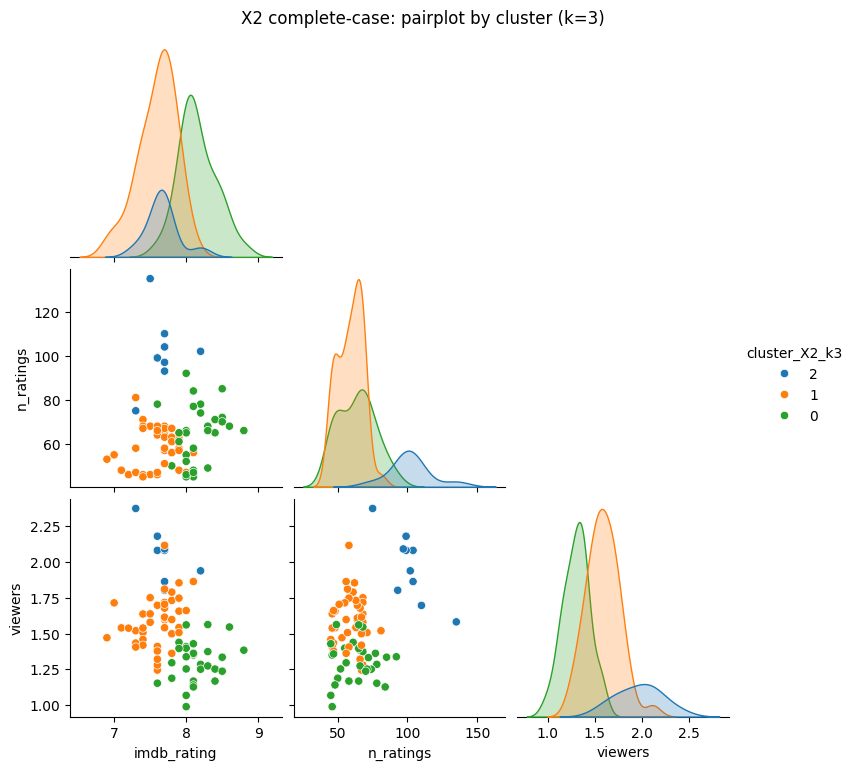

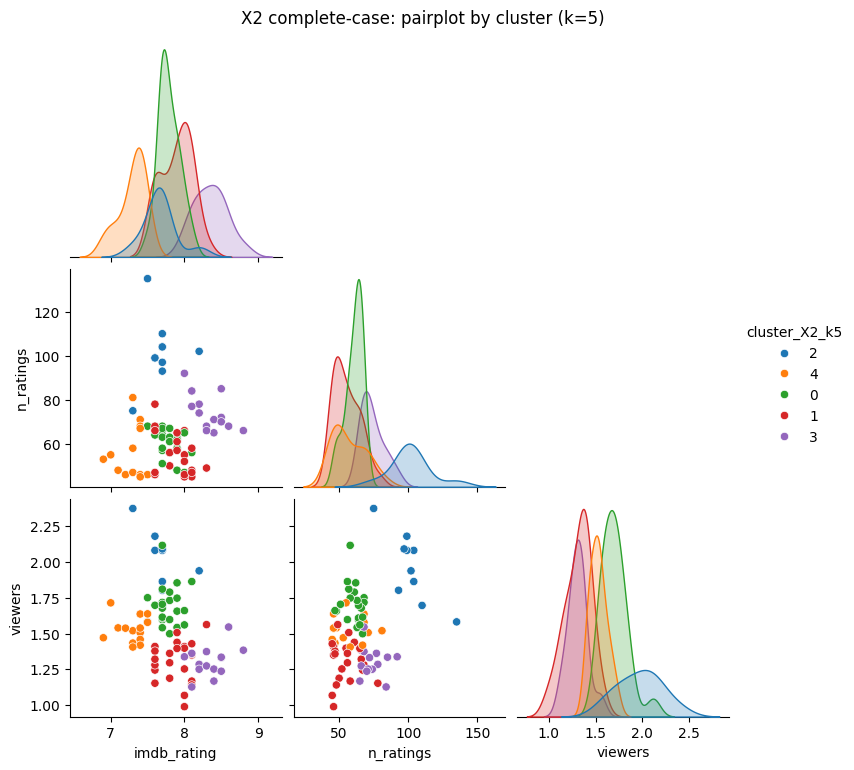

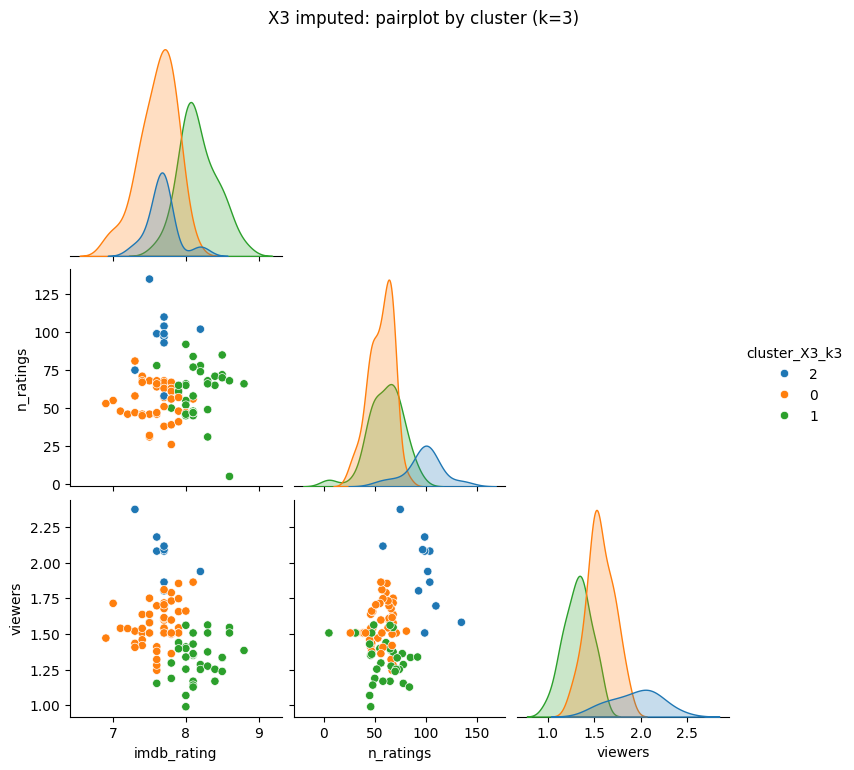

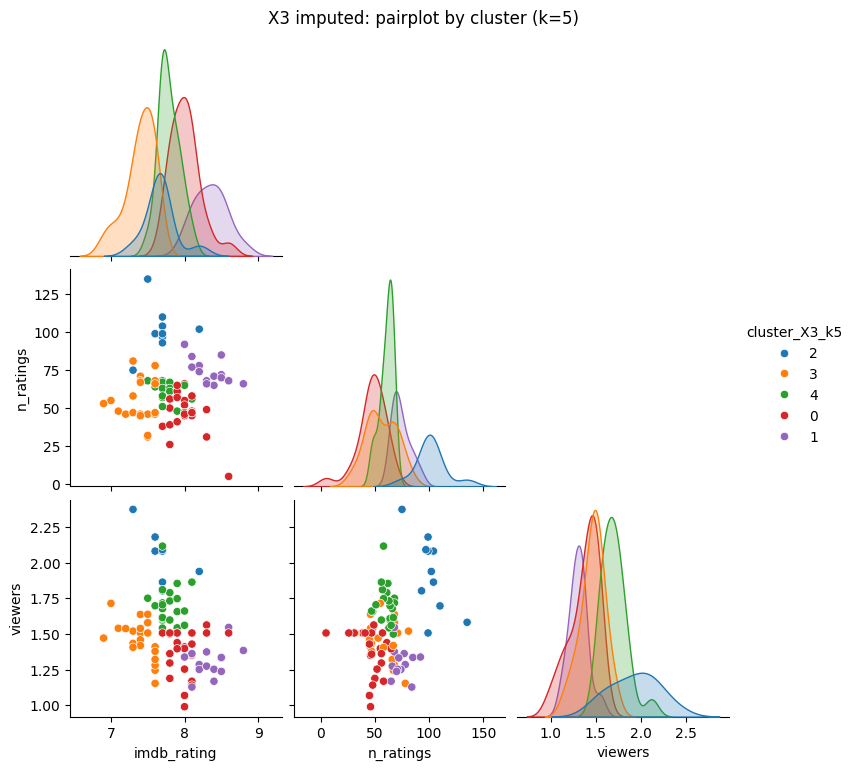

In [92]:
#C.3 Visuals ~ Pairplots and 3D cluster visualizations for X2 and X3 (k=3 and k=5)
import plotly.express as px

def plot_pairplot(df, label_col, title):
    """
    Pairplot for viewers, rating, votes, colored by cluster labels.
    """
    dfp = df[["imdb_rating", "n_ratings", "viewers", label_col]].dropna().copy()
    g = sns.pairplot(dfp, hue=label_col, diag_kind="kde", corner=True)
    g.fig.suptitle(title, y=1.02)
    plt.show()

def plotly_3d(df, label_col, title):
    dfp = df[["viewers", "imdb_rating", "n_ratings", label_col]].dropna().copy()
    fig = px.scatter_3d(
        dfp,
        x="viewers",
        y="imdb_rating",
        z="n_ratings",
        color=label_col,
        opacity=0.5,
        title=title,
        color_discrete_sequence=px.colors.qualitative.Set2
    )
    fig.update_traces(marker=dict(size=3))
    fig.show()

#Pairplots (X2)
plot_pairplot(episodes_view, "cluster_X2_k3", "X2 complete-case: pairplot by cluster (k=3)")
plot_pairplot(episodes_view, "cluster_X2_k5", "X2 complete-case: pairplot by cluster (k=5)")

#Pairplots (X3)
plot_pairplot(episodes_imp, "cluster_X3_k3", "X3 imputed: pairplot by cluster (k=3)")
plot_pairplot(episodes_imp, "cluster_X3_k5", "X3 imputed: pairplot by cluster (k=5)")

#X2 complete-case (viewers available)
plotly_3d(episodes_view, "cluster_X2_k3", "X2 complete-case: 3D clusters (k=3)")
plotly_3d(episodes_view, "cluster_X2_k5", "X2 complete-case: 3D clusters (k=5)")

#X3 imputed viewers (full 93 episodes)
plotly_3d(episodes_imp, "cluster_X3_k3", "X3 imputed viewers: 3D clusters (k=3)")
plotly_3d(episodes_imp, "cluster_X3_k5", "X3 imputed viewers: 3D clusters (k=5)")

**Interpretation for X2 pairplot (k=3):** <n>

The k equals 3 pairplot shows that the clusters are separated most clearly by vote volume and viewership, rather than by IMDb rating alone. One group stands out with noticeably higher vote counts and higher viewers, which looks like an engagement or exposure segment. The other two groups overlap more on viewers and votes, but they differ more consistently in rating level, which supports the idea that reception and engagement are related but not identical dimensions.

**Interpretation for X2 pairplot (k=5)** <n>

The k equals 3 pairplot shows that the clusters are separated most clearly by vote volume and viewership, rather than by IMDb rating alone. One group stands out with noticeably higher vote counts and higher viewers, which looks like an engagement or exposure segment. The other two groups overlap more on viewers and votes, but they differ more consistently in rating level, which supports the idea that reception and engagement are related but not identical dimensions.

**Interpretation for X3 pairplot (k=3)** <n>

The k equals 3 pairplot for the imputed dataset looks very similar to the complete case version, which supports the earlier ARI result showing strong agreement between X2 and X3. The same pattern appears where one cluster is driven mainly by high vote volume and relatively higher viewers, while the other clusters separate more by rating level with moderate overlap. This consistency suggests that the viewer based structure is not an artifact of dropping episodes with missing viewership.

**Interpretation for X3 pairplot (k=5)** <n>

Under k equals 5, the imputed pairplot again mirrors the complete case behavior: the segmentation refines the mid range group into smaller tiers, while the high engagement segment remains visible. There is still noticeable overlap among several clusters, especially in regions where ratings and viewership are close together, which implies that k equals 5 provides more detail but also makes boundaries less clean. Overall, the imputed version supports the same interpretation as X2 while keeping the full baseline sample.

**Interpretation for X2 3D scatter (k=3)** <n>

The 3D view makes the clustering logic easier to see because it shows separation across all three dimensions at once. One cluster appears shifted toward higher vote volume and generally higher viewership, even when rating is not always extreme, which is consistent with an engagement driven segment. The remaining clusters occupy overlapping parts of the space, with differences that appear more aligned to rating level than to viewers, reinforcing that viewership adds context but does not fully determine reception.

**Interpretation for X2 3D scatter (k=5)** <n>

With k equals 5, the 3D plot shows that refinement mainly splits the dense middle region into smaller subgroups rather than creating entirely new extremes. The high engagement behavior is still visible, but the other clusters form nearby clouds that differ by smaller changes in rating and viewers. This supports using k equals 5 as a refinement lens for more detail, while k equals 3 remains the cleaner summary.

**Interpretation for X3 3D scatter (k=3)** <n>

With k equals 5, the 3D plot shows that refinement mainly splits the dense middle region into smaller subgroups rather than creating entirely new extremes. The high engagement behavior is still visible, but the other clusters form nearby clouds that differ by smaller changes in rating and viewers. This supports using k equals 5 as a refinement lens for more detail, while k equals 3 remains the cleaner summary.

**Interpretation for X3 3D scatter (k=5)** <n>

The imputed 3D plot looks consistent with the complete case version, which supports the conclusion that the core clustering structure is stable across missing data handling choices. The same cluster stands out for higher vote volume and relatively higher viewership, while the remaining groups overlap more in viewers and votes and separate more by rating. This suggests that imputation did not introduce an artificial cluster pattern and mainly served to retain episodes for comparison.

# D. Hierarchical Clustering as a Method Robustness Check <n>


---


This section adds hierarchical clustering (Ward linkage) as a second, independent way to group episodes and check whether the same reception patterns found with KMeans still appear. The goal is not to replace the KMeans results, but to validate that the segmentation is not overly dependent on one clustering method or one set of assumptions. By comparing hierarchical group assignments at k equals 3 and k equals 5 to the KMeans buckets, this section helps confirm which patterns are stable and which ones are sensitive to the choice of clustering approach.

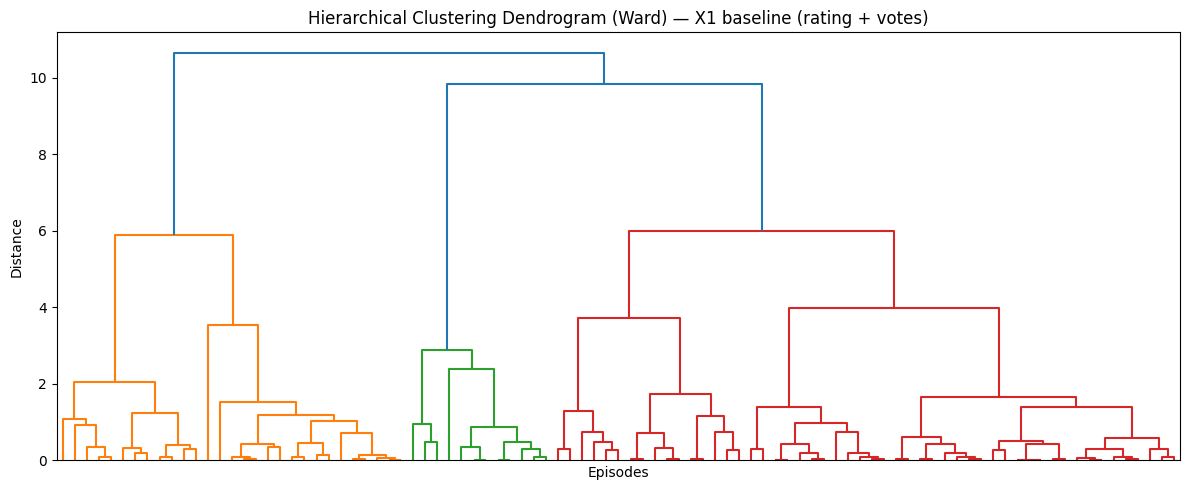

In [93]:
#D.1 Visual check: Ward dendrogram on the baseline feature space (ratings + votes)
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

Z_x1 = linkage(X1s, method="ward")

plt.figure(figsize=(12, 5))
dendrogram(Z_x1, no_labels=True)
plt.title("Hierarchical Clustering Dendrogram (Ward) — X1 baseline (rating + votes)")
plt.xlabel("Episodes")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

The dendrogram shows how episodes progressively merge into larger groups when similarity is measured using standardized IMDb rating and vote count. The larger vertical jumps near the top of the tree indicate meaningful separation points where combining clusters starts to require much larger “distance” increases. This supports the idea that there is real structure in the baseline feature space, and it also motivates checking both k equals 3 and k equals 5 cuts, since both represent plausible ways to partition the tree.

In [94]:
#D.2 Creating hierarchical cluster labels (k=3 and k=5) from the dendrogram
from scipy.cluster.hierarchy import fcluster

episodes_base = episodes_base.copy()

episodes_base["hier_X1_k3"] = fcluster(Z_x1, 3, criterion="maxclust").astype(str)
episodes_base["hier_X1_k5"] = fcluster(Z_x1, 5, criterion="maxclust").astype(str)

print("Hierarchical cluster sizes (X1, k=3):")
print(episodes_base["hier_X1_k3"].value_counts().sort_index())

print("\nHierarchical cluster sizes (X1, k=5):")
print(episodes_base["hier_X1_k5"].value_counts().sort_index())

Hierarchical cluster sizes (X1, k=3):
hier_X1_k3
1    29
2    12
3    52
Name: count, dtype: int64

Hierarchical cluster sizes (X1, k=5):
hier_X1_k5
1    12
2    17
3    12
4    16
5    36
Name: count, dtype: int64


The dendrogram shows how episodes progressively merge into larger groups when similarity is measured using standardized IMDb rating and vote count. The larger vertical jumps near the top of the tree indicate meaningful separation points where combining clusters starts to require much larger “distance” increases. This supports the idea that there is real structure in the baseline feature space, and it also motivates checking both k equals 3 and k equals 5 cuts, since both represent plausible ways to partition the tree.

In [95]:
#D.3 Comparing KMeans and hierarchical clustering (agreement scores and cross-tabs)
from sklearn.metrics import adjusted_rand_score
import pandas as pd

ari_k3 = adjusted_rand_score(episodes_base["cluster_k3"].astype(int), episodes_base["hier_X1_k3"].astype(int))
ari_k5 = adjusted_rand_score(episodes_base["cluster_k5"].astype(int), episodes_base["hier_X1_k5"].astype(int))

print("ARI (KMeans vs Hierarchical) — k=3:", round(ari_k3, 3))
print("ARI (KMeans vs Hierarchical) — k=5:", round(ari_k5, 3))

print("\nCrosstab (k=3): KMeans vs Hierarchical")
ct_k3 = pd.crosstab(episodes_base["cluster_k3"], episodes_base["hier_X1_k3"])
display(ct_k3)

print("\nCrosstab (k=5): KMeans vs Hierarchical")
ct_k5 = pd.crosstab(episodes_base["cluster_k5"], episodes_base["hier_X1_k5"])
display(ct_k5)

ARI (KMeans vs Hierarchical) — k=3: 0.717
ARI (KMeans vs Hierarchical) — k=5: 0.892

Crosstab (k=3): KMeans vs Hierarchical


hier_X1_k3,1,2,3
cluster_k3,,,
0,0,0,44
1,0,12,0
2,29,0,8



Crosstab (k=5): KMeans vs Hierarchical


hier_X1_k5,1,2,3,4,5
cluster_k5,,,,,
0,0,17,0,3,1
1,12,0,1,0,0
2,0,0,11,0,0
3,0,0,0,13,0
4,0,0,0,0,35


The agreement results suggest strong method robustness. For k equals 3, the ARI of 0.717 indicates that KMeans and Ward hierarchical clustering recover a largely consistent three bucket structure, with only one KMeans bucket being partially split under the hierarchical method. For k equals 5, agreement becomes even stronger (ARI 0.892), meaning the refined segmentation is highly stable across clustering approaches. The cross tabs make this easier to see: most KMeans clusters align almost one to one with hierarchical clusters, which supports treating the KMeans based interpretation as more than just a centroid artifact.

In [96]:
#D.4 Summarize hierarchical clusters (k=3 and k=5) to interpret what they represent
def cluster_summary_hier(df, label_col):
    return (
        df.groupby(label_col)
        .agg(
            n=("imdb_rating", "size"),
            mean_rating=("imdb_rating", "mean"),
            std_rating=("imdb_rating", "std"),
            mean_votes=("n_ratings", "mean"),
            min_rating=("imdb_rating", "min"),
            max_rating=("imdb_rating", "max"),
        )
        .sort_index()
    )

summary_hier_k3 = cluster_summary_hier(episodes_base, "hier_X1_k3")
summary_hier_k5 = cluster_summary_hier(episodes_base, "hier_X1_k5")

print("Hierarchical cluster summary (X1, k=3):")
display(summary_hier_k3)

print("Hierarchical cluster summary (X1, k=5):")
display(summary_hier_k5)

Hierarchical cluster summary (X1, k=3):


,n,mean_rating,std_rating,mean_votes,min_rating,max_rating
hier_X1_k3,,,,,,
1,29,8.224138,0.232464,56.068966,7.9,8.8
2,12,7.766667,0.214617,101.500000,7.5,8.2
3,52,7.609615,0.249909,57.846154,6.9,8.0


Hierarchical cluster summary (X1, k=5):


,n,mean_rating,std_rating,mean_votes,min_rating,max_rating
hier_X1_k5,,,,,,
1,12,8.400000,0.195402,71.666667,8.1,8.8
2,17,8.100000,0.169558,45.058824,7.9,8.6
3,12,7.766667,0.214617,101.500000,7.5,8.2
4,16,7.412500,0.268017,43.937500,6.9,7.8
5,36,7.697222,0.185913,64.027778,7.3,8.0


The hierarchical profile tables reinforce the same story that appeared in the KMeans results. At k equals 3, the method naturally separates a higher rated segment, a lower rated segment, and a distinct high vote segment, showing that vote volume functions as an engagement dimension that is not identical to rating level. When moving to k equals 5, the structure becomes more detailed: the high rated group splits into multiple tiers, and the lower rated group becomes more clearly isolated, while the high vote cluster remains stable. Across both k values, hierarchical clustering supports the same segmentation logic as KMeans, and the especially high agreement at k equals 5 suggests the refined bucket structure is robust to the choice of clustering method.

# E. Key Takeaways from Refinement Experiments


---

Across the refinement experiments, the main segmentation story stayed consistent while the details became clearer. Adding viewership (X2) introduced an exposure dimension that helped distinguish episodes that are widely watched or heavily rated from those that are simply well reviewed, and this pattern remained when missing viewership values were handled through imputation (X3), which allowed the full set of rated episodes to be retained without materially changing the cluster structure. Comparing k equals 3 and k equals 5 suggested that k equals 3 provides clean, easy to explain buckets, while k equals 5 acts as a useful refinement that mostly subdivides the dense mid range region into more specific tiers while preserving the engagement driven segment. Method robustness checks further strengthened confidence in this choice: hierarchical clustering produced a highly similar partition to KMeans, with especially strong agreement under k equals 5 (ARI approximately 0.892), indicating that the refined bucket structure is not dependent on one clustering method. For the remainder of Milestone 4, the primary specification will therefore emphasize the imputed viewership feature set (X3) with k equals 5 as the refined segmentation, while k equals 3 will be retained as a simplified summary version for clearer communication.